<a href="https://colab.research.google.com/github/CapitalJava/APM466-HW1/blob/master/APM466_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy import optimize
import numpy as np
import scipy.linalg as la

# read data
data = pd.read_csv("data.csv", encoding = "latin-1")
data['maturity date']=pd.to_datetime(data['maturity date'], format = "%d/%m/%Y")
data_mod = data.iloc[[9,11,13,3,10,14,17,19,27,25,18],:]
ds = data_mod.sort_values(by = ["maturity date"])
ds



,Bond,02/01/2020,03/01/2020,06/01/2020,07/01/2020,08/01/2020,09/01/2020,10/01/2020,13/01/2020,14/01/2020,15/01/2020,coupon,ISIN,issue date,maturity date
13,CDA 2020,99.85,99.86,99.86,99.86,99.86,99.86,99.86,99.86,99.86,99.86,1.50%,CA135087D929,14/10/2014,2020-03-01
9,CDA 2020,99.26,99.28,99.28,99.27,99.28,99.28,99.28,99.27,99.28,99.30,0.75%,CA135087E596,13/04/2015,2020-09-01
3,CDA 2021,98.89,98.93,98.95,98.94,98.92,98.92,98.88,98.90,98.90,98.93,0.75%,CA135087F254,19/10/2015,2021-03-01
11,CDA 2021,98.41,98.45,98.49,98.46,98.46,98.43,98.43,98.38,98.41,98.42,0.75%,CA135087F585,11/04/2016,2021-09-01
10,CDA 2022,97.57,97.63,97.66,97.65,97.64,97.60,97.61,97.57,97.58,97.61,0.50%,CA135087G328,11/10/2016,2022-03-01
14,CDA 2022,102.53,102.59,102.62,102.59,102.58,102.52,102.52,102.46,102.47,102.51,2.75%,CA135087ZU15,02/08/2011,2022-06-01
17,CDA 2023,100.31,100.42,100.48,100.45,100.44,100.35,100.31,100.27,100.31,100.38,1.75%,CA135087H490,06/10/2017,2023-03-01
19,CDA 2023,99.48,99.59,99.65,99.61,99.62,99.54,99.53,99.44,99.49,99.56,1.50%,CA135087A610,30/07/2012,2023-06-01
27,CDA 2024,102.52,102.65,102.75,102.58,102.68,102.53,102.47,102.46,102.54,102.64,2.25%,CA135087J546,05/10/2018,2024-03-01
25,CDA 19/24,98.72,98.95,99.29,99.11,99.25,98.99,99.03,99.06,98.99,99.10,1.50%,CA135087J967,05/04/2019,2024-09-01


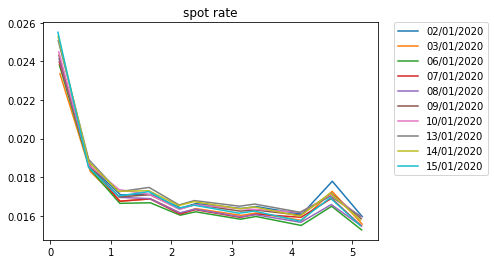

In [0]:
# spot rate

date_list = ["02/01/2020", "03/01/2020", "06/01/2020", "07/01/2020", "08/01/2020", "09/01/2020", "10/01/2020", "13/01/2020", "14/01/2020", "15/01/2020"]
for date in date_list:
  Today = pd.to_datetime(date, format = "%d/%m/%Y")
  last_coupon_payment = [pd.to_datetime("01/09/2019", format = "%d/%m/%Y"), pd.to_datetime("01/12/2019", format = "%d/%m/%Y")]
  spot = []
  time = []
  tempory_spot = []
  tempory_time = []
  for row in ds.iterrows():
    # calculate dirty price
    coupon = (float(row[1]["coupon"].strip('%')) / 100) * 100 / 2
    if row[1]["maturity date"] == pd.to_datetime("2022-06-01") or row[1]["maturity date"] == pd.to_datetime("2023-06-01"):
      payment_date = last_coupon_payment[1]
    else:
      payment_date = last_coupon_payment[0]
    day = (Today - payment_date).days / 180
    dirty_price = row[1][date] + day * coupon

    t = ((row[1]["maturity date"] - Today).days) / 365

    if row[1]["maturity date"] == pd.to_datetime("2022-06-01") or row[1]["maturity date"] == pd.to_datetime("2023-06-01"):
      avg_time = []
      avg_spot = [] 
      for j in range(len(tempory_spot)-1):
        avg_spot.append((tempory_spot[j]+tempory_spot[j+1])/2)
        avg_time.append((tempory_time[j]+tempory_time[j+1])/2)
      sum = 0
      for i in range(len(avg_spot)):  
        sum += math.exp(-avg_spot[i]*avg_time[i])
      r = - math.log((dirty_price-coupon*sum)/(100+coupon)) / t
      tempory_r = 2 * r - spot[-1]
      tempory_spot.append(tempory_r)
      t_tempory = ((row[1]["maturity date"] - Today).days + 90) / 365
      tempory_time.append(t_tempory)
    else:
      sum = 0
      for i in range(len(tempory_spot)):  
        sum += math.exp(-tempory_spot[i]*tempory_time[i])
      r = - math.log((dirty_price-coupon*sum)/(100+coupon)) / t
      tempory_spot.append(r)
      tempory_time.append(t)
    spot.append(r)
    time.append(t)
  plt.plot(time, spot, label = date)
plt.title('spot rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()


covariance:
[[1.11732788e-04 5.75796297e-05 9.77490390e-05 1.09426806e-04
  1.20511682e-04]
 [5.75796297e-05 1.04098437e-04 1.17415183e-04 1.27959152e-04
  1.52120720e-04]
 [9.77490390e-05 1.17415183e-04 1.56094726e-04 1.79157545e-04
  2.10664771e-04]
 [1.09426806e-04 1.27959152e-04 1.79157545e-04 2.71510683e-04
  2.84041675e-04]
 [1.20511682e-04 1.52120720e-04 2.10664771e-04 2.84041675e-04
  3.43057358e-04]]
eigenvalue:
[8.55723991e-04+0.j 6.46952565e-05+0.j 4.36523357e-05+0.j
 2.94841031e-06+0.j 1.94739985e-05+0.j]
eigenvectors:
[[ 0.25694733  0.90064169  0.23954818  0.24855615  0.06049061]
 [ 0.30104034 -0.01513234 -0.74565427  0.528424   -0.2718704 ]
 [ 0.41100331  0.20809138 -0.39704586 -0.79374009 -0.01027223]
 [ 0.54065184 -0.23170197  0.46239681 -0.00350613 -0.66346566]
 [ 0.61816233 -0.30270073  0.12312659  0.17015372  0.69435954]]


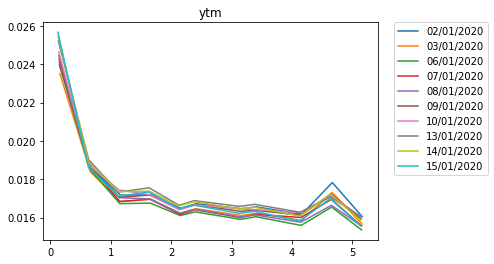

In [0]:
# ytm
cov = np.zeros([10, 5])
date_list = ["02/01/2020", "03/01/2020", "06/01/2020", "07/01/2020", "08/01/2020", "09/01/2020", "10/01/2020", "13/01/2020", "14/01/2020", "15/01/2020"]
cov_row_index = 0
for date in date_list:
  Today = pd.to_datetime(date, format = "%d/%m/%Y")
  last_coupon_payment = [pd.to_datetime("01/09/2019", format = "%d/%m/%Y"), pd.to_datetime("01/12/2019", format = "%d/%m/%Y")]
  ytm_list = []
  time_list = []

  for row in ds.iterrows():
    # calculate dirty price
    coupon = (float(row[1]["coupon"].strip('%')) / 100) * 100 / 2
    if row[1]["maturity date"] == pd.to_datetime("2022-06-01") or row[1]["maturity date"] == pd.to_datetime("2023-06-01"):
      payment_date = last_coupon_payment[1]
    else:
      payment_date = last_coupon_payment[0]
    day = (Today - payment_date).days / 180
    dirty_price = row[1][date] + day * coupon
    
    def f(y):

      i = (row[1]["maturity date"] - Today).days // 180 + 1
      t = ((row[1]["maturity date"] - Today).days) / 365
      sum = 100/(1+y/2)**(2*t)
      while i > 0:
        sum += coupon/(1+y/2)**(2*t)
        t = t - 180/365
        i = i - 1
      return sum - dirty_price
    ytm = optimize.newton(f, 0.1)
    t = ((row[1]["maturity date"] - Today).days) / 365
    ytm_list.append(ytm)
    time_list.append(t)

  # calculate covariance
  new_row = np.array(np.interp([1,2,3,4,5], time_list, ytm_list))
  cov[cov_row_index,:] = new_row
  cov_row_index += 1 
  plt.plot(time_list, ytm_list, label = date)
cov_final = np.zeros([5,9])
for cov_final_row_index in range(len(cov.T)):
  ls = []
  for k in range(len(cov.T[cov_final_row_index])-1):
    ls.append(np.log(cov.T[cov_final_row_index][k+1]/cov.T[cov_final_row_index][k]))
  cov_final[cov_final_row_index] = np.array(ls)

eigvals, eigvecs = la.eig(np.cov(cov_final))

print("covariance:")
print(np.cov(cov_final)) 
print("eigenvalue:")
print(eigvals)
print("eigenvectors:")
print(eigvecs)

plt.title('ytm')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()




covariance:
[[5.73293450e-08 4.87411002e-08 3.05384728e-08 3.62269269e-08]
 [4.87411002e-08 6.27367029e-08 5.18815401e-08 6.30608964e-08]
 [3.05384728e-08 5.18815401e-08 5.87819760e-08 6.42805272e-08]
 [3.62269269e-08 6.30608964e-08 6.42805272e-08 9.63551173e-08]]
eigenvalue:
[2.21560870e-07+0.j 3.98941219e-08+0.j 3.06670110e-09+0.j
 1.06814487e-08+0.j]
eigenvectors:
[[ 0.37478794  0.79492458  0.4338254   0.19855586]
 [ 0.51219649  0.24084266 -0.80727235 -0.16721524]
 [ 0.47444497 -0.24506958  0.38394205 -0.75328041]
 [ 0.6099924  -0.50003063  0.11267379  0.60430395]]


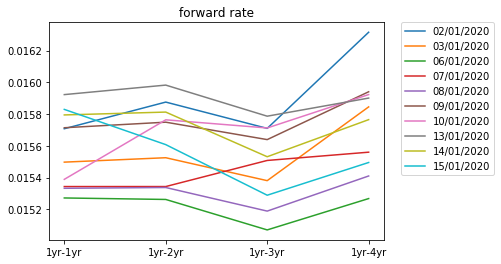

In [0]:
# forward rate
cov = np.zeros([10, 4])
date_list = ["02/01/2020", "03/01/2020", "06/01/2020", "07/01/2020", "08/01/2020", "09/01/2020", "10/01/2020", "13/01/2020", "14/01/2020", "15/01/2020"]
forward_period = ["1yr-1yr", "1yr-2yr", "1yr-3yr", "1yr-4yr"]
cov_row_index = 0
for date in date_list:
  Today = pd.to_datetime(date, format = "%d/%m/%Y")
  last_coupon_payment = [pd.to_datetime("01/09/2019", format = "%d/%m/%Y"), pd.to_datetime("01/12/2019", format = "%d/%m/%Y")]
  spot = []
  time = []
  tempory_spot = []
  tempory_time = []
  for row in ds.iterrows():
    # calculate dirty price
    coupon = (float(row[1]["coupon"].strip('%')) / 100) * 100 / 2
    if row[1]["maturity date"] == pd.to_datetime("2022-06-01") or row[1]["maturity date"] == pd.to_datetime("2023-06-01"):
      payment_date = last_coupon_payment[1]
    else:
      payment_date = last_coupon_payment[0]
    day = (Today - payment_date).days / 180
    dirty_price = row[1][date] + day * coupon

    t = ((row[1]["maturity date"] - Today).days) / 365

    if row[1]["maturity date"] == pd.to_datetime("2022-06-01") or row[1]["maturity date"] == pd.to_datetime("2023-06-01"):
      avg_time = []
      avg_spot = [] 
      for j in range(len(tempory_spot)-1):
        avg_spot.append((tempory_spot[j]+tempory_spot[j+1])/2)
        avg_time.append((tempory_time[j]+tempory_time[j+1])/2)
      sum = 0
      for i in range(len(avg_spot)):  
        sum += math.exp(-avg_spot[i]*avg_time[i])
      r = - math.log((dirty_price-coupon*sum)/(100+coupon)) / t
      tempory_r = 2 * r - spot[-1]
      tempory_spot.append(tempory_r)
      t_tempory = ((row[1]["maturity date"] - Today).days + 90) / 365
      tempory_time.append(t_tempory)
    else:
      sum = 0
      for i in range(len(tempory_spot)):  
        sum += math.exp(-tempory_spot[i]*tempory_time[i])
      r = - math.log((dirty_price-coupon*sum)/(100+coupon)) / t
      tempory_spot.append(r)
      tempory_time.append(t)
    spot.append(r)
    time.append(t)
    
  # calculate forward
  forward_list = []
  spot_list = []
  for num in range(5):
    num_year = num + 1
    spot_rate = np.interp(num_year, time, spot)
    spot_list.append(spot_rate)
  num2 = 1
  while num2 < len(spot_list):
    forward_rate = ((1+spot_list[num2])**(num2+1)/(1+spot_list[0]))**(1/num2) - 1
    forward_list.append(forward_rate)
    num2 += 1
  # calcualte covariance
  cov[cov_row_index] = forward_list
  cov_row_index += 1

  plt.plot(forward_period, forward_list, label = date)

eigvals, eigvecs = la.eig(np.cov(cov.T))

print("covariance:")
print(np.cov(cov.T))
print("eigenvalue:")
print(eigvals)
print("eigenvectors:")
print(eigvecs)

plt.title('forward rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.show()
